In [1]:
pip install gymnasium numpy pandas tensorflow matplotlib stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('/content/intraday_5min_IBM.csv')


# Drop the timestamp column for RL environment
df.drop(columns=['timestamp'], inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume']])

# Handle missing values (if any)
df.dropna(inplace=True)

# Save the preprocessed data
df.to_csv('preprocessed_stock_data.csv', index=False)

print(df.head())


       open      high       low     close    volume
0  0.884615  1.000000  0.828571  1.000000  0.000130
1  0.876923  0.918033  0.885714  0.928571  0.000012
2  0.807692  0.803279  0.821429  0.828571  0.000015
3  0.823077  0.811475  0.821429  0.821429  0.000015
4  0.823077  0.811475  0.835714  0.835714  0.000003


Streaming output truncated to the last 5000 lines.
Step: 412, Action: 2, Reward: 0, Total Profit: -0.01
Step: 413, Action: 2, Reward: 0, Total Profit: -0.01
Step: 414, Action: 2, Reward: 0, Total Profit: -0.01
Step: 415, Action: 1, Reward: 0.0, Total Profit: -0.01
Step: 416, Action: 2, Reward: 0.14285714285712459, Total Profit: 0.13285714285712458
Step: 417, Action: 2, Reward: 0, Total Profit: 0.13285714285712458
Step: 418, Action: 2, Reward: 0, Total Profit: 0.13285714285712458
Step: 419, Action: 1, Reward: 0.035714285714306016, Total Profit: 0.1685714285714306
Step: 420, Action: 2, Reward: -0.035714285714306016, Total Profit: 0.13285714285712458
Step: 421, Action: 1, Reward: 0.1785714285714306, Total Profit: 0.3114285714285552
Step: 422, Action: 2, Reward: -0.16428571428569683, Total Profit: 0.14714285714285835
Step: 423, Action: 1, Reward: -0.035714285714306016, Total Profit: 0.11142857142855234
Step: 424, Action: 2, Reward: 0.0714285714285694, Total Profit: 0.18285714285712173
Step

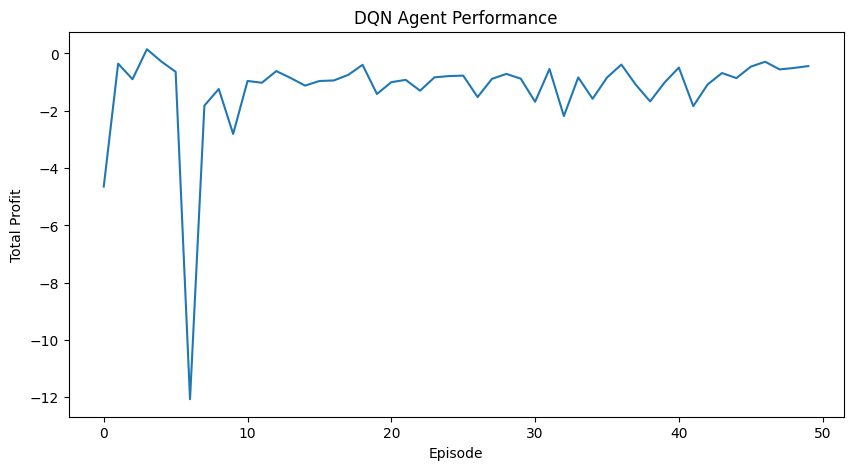

IndexError: list index out of range

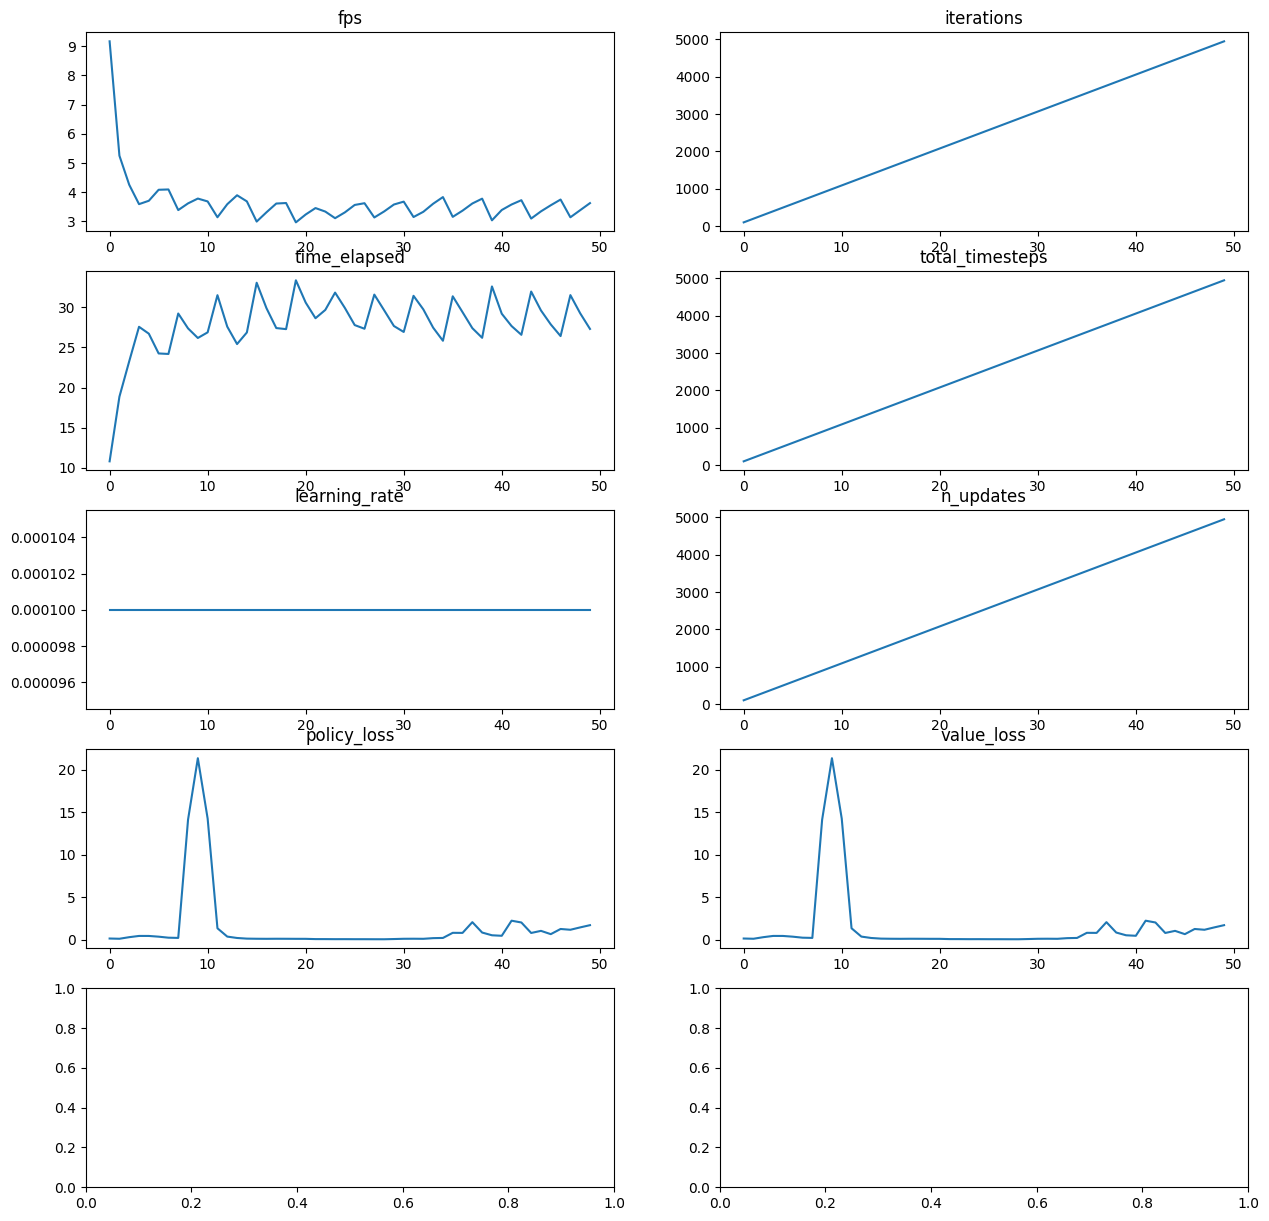

In [4]:
import gymnasium as gym
import numpy as np
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt
import time
import os

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.action_space = gym.spaces.Discrete(3)  # buy, hold, sell
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(df.shape[1] + 1,), dtype=np.float32)  # +1 for number of trades
        self.trades = []  # Initialize trades here
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.total_profit = 0
        self.done = False
        self.trades = []  # Reset trades
        self.state = self._get_state()
        return self.state, {}

    def step(self, action):
        prev_val = self.df.iloc[self.current_step]['close']
        self.current_step += 1

        if self.current_step >= len(self.df) - 1:
            self.done = True
        else:
            self.done = False

        current_val = self.df.iloc[self.current_step]['close']
        reward = 0
        if action == 1:  # buy
            self.trades.append(current_val)
            reward = current_val - prev_val  # small reward for increase
        elif action == 2:  # sell
            if self.trades:
                bought_price = self.trades.pop(0)
                reward = current_val - bought_price
        else:  # hold
            reward = -0.01  #penalty for holding (ceza)

        self.state = self._get_state()
        self.total_profit += reward
        return self.state, reward, self.done, False, {}

    def _get_state(self):
        state = self.df.iloc[self.current_step].values
        state = np.append(state, [len(self.trades)])  # Add number of trades to the state
        return state / np.max(state)  # Normalization

    def render(self, mode='rgb_array'):
        fig, ax = plt.subplots()
        ax.plot(self.df['close'][:self.current_step])
        ax.set_title(f'Step: {self.current_step}, Profit: {self.total_profit}')
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.show()

# Define Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Build Q-Network
def build_q_network(input_shape, num_actions):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(num_actions))
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='mse')
    return model

# DQN Algoritması
class DQNAgent:
    def __init__(self, env, replay_memory_size=50000, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, target_update=10):
        self.env = env
        self.memory = ReplayMemory(replay_memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update
        self.num_actions = env.action_space.n
        self.q_network = build_q_network(env.observation_space.shape[0], self.num_actions)  # Adjusted for additional state feature
        self.target_network = build_q_network(env.observation_space.shape[0], self.num_actions)
        self.update_target_network()

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = self.q_network.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_values[0])

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return 0
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        q_values = self.q_network.predict(states, verbose=0)
        q_next = self.target_network.predict(next_states, verbose=0)
        targets = q_values.copy()
        for i in range(self.batch_size):
            targets[i, actions[i]] = rewards[i] + (1 - dones[i]) * self.gamma * np.max(q_next[i])
        loss = self.q_network.train_on_batch(states, targets)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss

    def train(self, num_episodes):
        episode_profits = []
        training_metrics = {
            'fps': [],
            'iterations': [],
            'time_elapsed': [],
            'total_timesteps': [],
            'learning_rate': [],
            'n_updates': [],
            'policy_loss': [],
            'value_loss': []
        }

        start_time = time.time()
        total_timesteps = 0
        n_updates = 0

        for episode in range(num_episodes):
            episode_start_time = time.time()
            state, _ = self.env.reset()
            done = False
            total_profit = 0
            timesteps_this_episode = 0
            policy_loss = 0
            value_loss = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                loss = self.train_step()
                policy_loss += loss
                value_loss += loss
                total_profit += reward
                timesteps_this_episode += 1
                total_timesteps += 1
                n_updates += 1

                # Print action details
                print(f"Step: {total_timesteps}, Action: {action}, Reward: {reward}, Total Profit: {total_profit}")

            if episode % self.target_update == 0:
                self.update_target_network()

            episode_time_elapsed = time.time() - episode_start_time
            training_metrics['time_elapsed'].append(episode_time_elapsed)
            training_metrics['total_timesteps'].append(total_timesteps)
            training_metrics['iterations'].append(total_timesteps)
            training_metrics['fps'].append(timesteps_this_episode / episode_time_elapsed)
            training_metrics['learning_rate'].append(0.0001)
            training_metrics['n_updates'].append(n_updates)
            training_metrics['policy_loss'].append(policy_loss / timesteps_this_episode)
            training_metrics['value_loss'].append(value_loss / timesteps_this_episode)

            episode_profits.append(total_profit)

            # Print training metrics for current episode
            print(f"Episode {episode}:")
            print(f"    Total Profit: {total_profit}")
            print(f"    FPS: {training_metrics['fps'][-1]:.2f}")
            print(f"    Iterations: {training_metrics['iterations'][-1]}")
            print(f"    Time Elapsed: {training_metrics['time_elapsed'][-1]:.2f}")
            print(f"    Total Timesteps: {training_metrics['total_timesteps'][-1]}")
            print(f"    Learning Rate: {training_metrics['learning_rate'][-1]}")
            print(f"    Updates: {training_metrics['n_updates'][-1]}")
            print(f"    Policy Loss: {training_metrics['policy_loss'][-1]}")
            print(f"    Value Loss: {training_metrics['value_loss'][-1]}")

        # Save episode_profits and training_metrics for plotting
        np.save('episode_profits.npy', episode_profits)
        np.save('training_metrics.npy', training_metrics)

# Load preprocessed data
df = pd.read_csv('preprocessed_stock_data.csv')

# Create and wrap the environment
env = StockTradingEnv(df)

# Initialize DQN Agent
dqn_agent = DQNAgent(env)

# Train the agent
dqn_agent.train(num_episodes=50)

# Evaluate the agent
total_profit = dqn_agent.env.total_profit
print(f'Total Profit: {total_profit}')

def plot_results():
  episode_profits = np.load('episode_profits.npy')
  training_metrics = np.load('training_metrics.npy', allow_pickle=True).item()

  plt.figure(figsize=(10,5))
  plt.plot(episode_profits)
  plt.xlabel('Episode')
  plt.ylabel('Total Profit')
  plt.title('DQN Agent Performance')
  plt.show()

  fig, axs = plt.subplots(5,2,figsize=(15,15))
  metrics_keys = list(training_metrics.keys())
  for i in range(5):
    for j in range(2):
      key = metrics_keys[i*2+j]
      axs[i,j].plot(training_metrics[key])
      axs[i,j].set_title(key)
  plt.tight_layout()
  plt.show()

plot_results()
StockTradinEnv.render()